# ADSR - Attack, Delay, Sustain, Release

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importing Everything from Previous Notebook

In [12]:
import numpy as np

def get_frequency(n, base_freq = 440):
    return 2 ** (((n+1) - 49) / 12 ) * base_freq

def get_key_frequency_mapping(base_freq = 440):
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    keys_with_octaves = np.array([n + str(i) for i in range(8+1) for n in notes]) # 8 + 1 such that we have 8 indexes
    start_note = np.where(keys_with_octaves == 'A0')[0][0]
    end_note = np.where(keys_with_octaves == 'C8')[0][0]    
    
    keys = keys_with_octaves[start_note:end_note + 1] # 88 Keys
    
    note_dict = dict(zip(keys, [get_frequency(n, base_freq = base_freq) for n in range(len(keys))]))
    note_dict[''] = 0 # No Note
    return note_dict


def sine_note(freq, duration, sample_rate = 44100, A = 4096):
    t = np.linspace(0, duration, int(sample_rate * duration)) # Time Axis
    note = A * np.sin(2 * np.pi * freq * t)
    return note


keys = get_key_frequency_mapping()
def note_out(key, duration=1, amplitude = 3064):
    if key not in keys.keys():
        print(f"{key} is not a valid key. Please enter one the following {keys.keys()}")
        return
    else:
        freq = keys[key]
        return sine_note(freq, duration = duration, A = amplitude)



# import IPython.display as ipd  # Use this to play Waves on Jupyter Notebook

# # C note

# ipd.Audio(note_out('C4'), rate=44100, autoplay=True)


def overtone(freq, duration, factor, sample_rate = 44100, amplitude = 4096):
    frequencies = np.array([freq*(x+1) for x in range(len(factor))])
    amplitudes = np.array([amplitude*x for x in factor])
    
    fundamental = sine_note(frequencies[0], duration, sample_rate, amplitudes[0])
    for i in range(1, len(factor)):
        overtone = sine_note(frequencies[i], duration, sample_rate, amplitudes[i])
        fundamental += overtone
    return fundamental

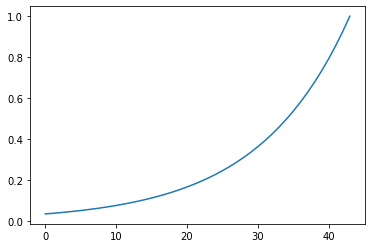

In [13]:
interval = int(2* 440)

len_A = np.maximum(int(interval * 0.05), 1)
decay_A = 0.075

A = 1/np.array([(1-decay_A)**n for n in range(len_A)])
A /= np.nanmax(A)
plt.plot(A)

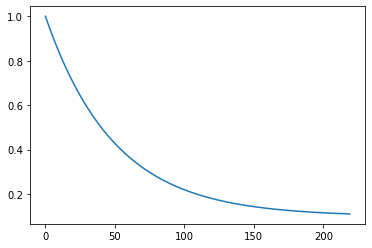

In [15]:
interval = int(2* 440)
sustain_level = 0.1
len_D = np.maximum(int(interval * 0.25), 1)
decay_D = 0.02

D = np.array([(1-decay_D)**n for n in range(len_D)])
D = D*(1-sustain_level)+sustain_level
plt.plot(D)

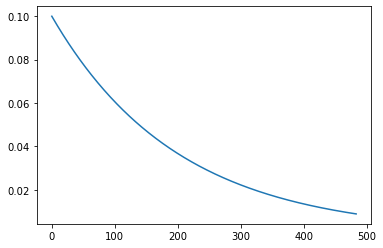

In [49]:
len_S = np.maximum(int(interval * 0.55), 1)
decay_S = 0.005
sustain_level = 0.1

S = np.array([(1-decay_S)**n for n in range(len_S)])
S = S*sustain_level
plt.plot(S)

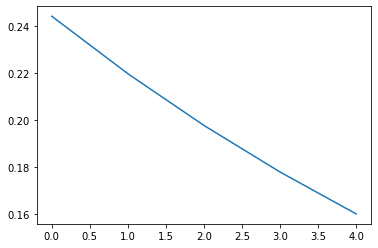

In [19]:
smoothing = np.array([0.1*(1-0.1)**n for n in range(5)])
smoothing = smoothing/np.nansum(smoothing)
plt.plot(smoothing)

In [43]:
# Nice implementation by Katie He

def adsr_weights(freq, duration, length, decay, sustain_level, sample_rate = 44100):
    intervals = int(duration * freq)
    len_A = np.maximum(int(intervals*length[0]),1)
    len_D = np.maximum(int(intervals*length[1]),1)
    len_S = np.maximum(int(intervals*length[2]),1)
    len_R = np.maximum(int(intervals*length[3]),1)
    
    decay_A = decay[0]
    decay_D = decay[1]
    decay_S = decay[2]
    decay_R = decay[3]
    
    A = 1/np.array([(1-decay_A)**n for n in range(len_A)])
    A = A/np.nanmax(A)
    D = np.array([(1-decay_D)**n for n in range(len_D)])
    D = D*(1-sustain_level)+sustain_level
    S = np.array([(1-decay_S)**n for n in range(len_S)])
    S = S*sustain_level
    R = np.array([(1-decay_R)**n for n in range(len_R)])
    R = R*S[-1]
    
    weights = np.concatenate((A,D,S,R))
    smoothing = np.array([0.1*(1-0.1)**n for n in range(5)])
    smoothing = smoothing/np.nansum(smoothing)
    weights = np.convolve(weights, smoothing, mode='same')
    
    weights = np.repeat(weights, int(sample_rate*duration/intervals))
    tail = int(sample_rate*duration-weights.shape[0])
    if tail > 0:
        weights = np.concatenate((weights, weights[-1]-weights[-1]/tail*np.arange(tail)))
    return weights

In [44]:
factor = np.array([0.73168812, 0.16083298, 0.06460201, 0.00744849, 0.0174458 ,
       0.00318635, 0.01479625])

In [45]:
note = overtone(keys["C4"], duration = 2, factor = factor)
ipd.Audio(note, rate=44100, autoplay=True)

In [48]:
weights = adsr_weights(keys["C4"], duration=2, length=[0.1, 0.20, 0.50, 0.20], decay=[0.01,0.02,0.005,0.1], sustain_level=0.2)
data = note*weights
data = data*(4096/np.max(data))
ipd.Audio(data, rate=44100, autoplay=True)